# Sentiment Analysis on student feedback

### 1st Survey **(Student Experience Survey)**



## Importing & Authenticating

In [ ]:
import nltk
from google.colab import auth
auth.authenticate_user()

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

In [ ]:

import numpy as np
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer 
from textblob import TextBlob



In [ ]:
# Reading table feedback_data from google BigQuery
Feedback_data = pandas_gbq.read_gbq(f'SELECT * FROM `surveyproject-378222.Capstone_Project.Feedback`',project_id='surveyproject-378222', dialect='standard') 

Downloading: 100%|██████████|


In [ ]:
Feedback_data

,ID,Feedback
0,270,None
1,185,None
2,97,None
3,165,None
4,325,None
...,...,...
348,92,I am very disappointed with this program. The ...
349,196,I came to St. Clair college to gain experience...
350,114,I think there is a gap between the college off...
351,230,College should think of having 3 days per week...


# Data Preprocessing 

##1) Normalization

In [ ]:
fdk = Feedback_data
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].str.replace(r"@[A-Za-z0-9]+", "")  # remove Twitter usernames
    df[new_text_field_name] = df[new_text_field_name].str.replace(r"[^0-9A-Za-z \t]", "")  # remove non-alphanumeric characters
    df[new_text_field_name] = df[new_text_field_name].str.replace(r"http\S+", "")  # remove URLs
    df[new_text_field_name] = df[new_text_field_name].str.replace(r"^rt", "")  # remove retweet indicator
    df[new_text_field_name] = df[new_text_field_name].str.strip()  # remove leading/trailing whitespace 
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].str.replace('\d+', '') 
    return df
data_clean = clean_text(fdk , 'Feedback', 'text_clean')
data_clean.head()

<ipython-input-5-09e31bd14f19>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[new_text_field_name] = df[new_text_field_name].str.replace(r"@[A-Za-z0-9]+", "")  # remove Twitter usernames
<ipython-input-5-09e31bd14f19>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[new_text_field_name] = df[new_text_field_name].str.replace(r"[^0-9A-Za-z \t]", "")  # remove non-alphanumeric characters
<ipython-input-5-09e31bd14f19>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[new_text_field_name] = df[new_text_field_name].str.replace(r"http\S+", "")  # remove URLs
<ipython-input-5-09e31bd14f19>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[new_text_field_name] = df[new_text_field_name].str.replace(r"^rt", "")  # remove retweet indicator
<ipython-input-5-09e31bd14f19>:11: FutureWarning:

,ID,Feedback,text_clean
0,270,None,None
1,185,None,None
2,97,None,None
3,165,None,None
4,325,None,None


In [ ]:
fdk


,ID,Feedback,text_clean
0,270,None,None
1,185,None,None
2,97,None,None
3,165,None,None
4,325,None,None
...,...,...,...
348,92,I am very disappointed with this program. The ...,i am very disappointed with this program the p...
349,196,I came to St. Clair college to gain experience...,i came to st clair college to gain experience ...
350,114,I think there is a gap between the college off...,i think there is a gap between the college off...
351,230,College should think of having 3 days per week...,college should think of having days per week ...


##2) Stop words

In [ ]:
stop_words = set(stopwords.words('english'))
data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]) if x is not None else '')
data_clean.head()

#data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,ID,Feedback,text_clean
0,270,None,
1,185,None,
2,97,None,
3,165,None,
4,325,None,


In [ ]:
fdk

,ID,Feedback,text_clean
0,270,None,
1,185,None,
2,97,None,
3,165,None,
4,325,None,
...,...,...,...
348,92,I am very disappointed with this program. The ...,disappointed program professors seem expect st...
349,196,I came to St. Clair college to gain experience...,came st clair college gain experience meeting ...
350,114,I think there is a gap between the college off...,think gap college offering services students a...
351,230,College should think of having 3 days per week...,college think days per week also college follo...


##3) Tokenization

In [ ]:
data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x: word_tokenize(x))
data_clean.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,ID,Feedback,text_clean,text_tokens
0,270,None,,[]
1,185,None,,[]
2,97,None,,[]
3,165,None,,[]
4,325,None,,[]


In [ ]:
fdk

,ID,Feedback,text_clean,text_tokens
0,270,None,,[]
1,185,None,,[]
2,97,None,,[]
3,165,None,,[]
4,325,None,,[]
...,...,...,...,...
348,92,I am very disappointed with this program. The ...,disappointed program professors seem expect st...,"[disappointed, program, professors, seem, expe..."
349,196,I came to St. Clair college to gain experience...,came st clair college gain experience meeting ...,"[came, st, clair, college, gain, experience, m..."
350,114,I think there is a gap between the college off...,think gap college offering services students a...,"[think, gap, college, offering, services, stud..."
351,230,College should think of having 3 days per week...,college think days per week also college follo...,"[college, think, days, per, week, also, colleg..."


##4) Stemming

In [ ]:
def word_stemmer(Feedback):
    stem_text = [PorterStemmer().stem(i) for i in Feedback]
    return stem_text
data_clean['text_tokens_stem'] = data_clean['text_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head()

,ID,Feedback,text_clean,text_tokens,text_tokens_stem
0,270,None,,[],[]
1,185,None,,[],[]
2,97,None,,[],[]
3,165,None,,[],[]
4,325,None,,[],[]


In [ ]:
fdk

,ID,Feedback,text_clean,text_tokens,text_tokens_stem
0,270,None,,[],[]
1,185,None,,[],[]
2,97,None,,[],[]
3,165,None,,[],[]
4,325,None,,[],[]
...,...,...,...,...,...
348,92,I am very disappointed with this program. The ...,disappointed program professors seem expect st...,"[disappointed, program, professors, seem, expe...","[disappoint, program, professor, seem, expect,..."
349,196,I came to St. Clair college to gain experience...,came st clair college gain experience meeting ...,"[came, st, clair, college, gain, experience, m...","[came, st, clair, colleg, gain, experi, meet, ..."
350,114,I think there is a gap between the college off...,think gap college offering services students a...,"[think, gap, college, offering, services, stud...","[think, gap, colleg, offer, servic, student, a..."
351,230,College should think of having 3 days per week...,college think days per week also college follo...,"[college, think, days, per, week, also, colleg...","[colleg, think, day, per, week, also, colleg, ..."


##5) Lemmatization

In [ ]:
def word_lemmatizer(Feedback):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in Feedback]
    return lem_text
data_clean['text_tokens_lemma'] = data_clean['text_tokens'].apply(lambda x: word_lemmatizer(x))
data_clean.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


,ID,Feedback,text_clean,text_tokens,text_tokens_stem,text_tokens_lemma
0,270,None,,[],[],[]
1,185,None,,[],[],[]
2,97,None,,[],[],[]
3,165,None,,[],[],[]
4,325,None,,[],[],[]


In [ ]:
fdk

,ID,Feedback,text_clean,text_tokens,text_tokens_stem,text_tokens_lemma
0,270,None,,[],[],[]
1,185,None,,[],[],[]
2,97,None,,[],[],[]
3,165,None,,[],[],[]
4,325,None,,[],[],[]
...,...,...,...,...,...,...
348,92,I am very disappointed with this program. The ...,disappointed program professors seem expect st...,"[disappointed, program, professors, seem, expe...","[disappoint, program, professor, seem, expect,...","[disappointed, program, professor, seem, expec..."
349,196,I came to St. Clair college to gain experience...,came st clair college gain experience meeting ...,"[came, st, clair, college, gain, experience, m...","[came, st, clair, colleg, gain, experi, meet, ...","[came, st, clair, college, gain, experience, m..."
350,114,I think there is a gap between the college off...,think gap college offering services students a...,"[think, gap, college, offering, services, stud...","[think, gap, colleg, offer, servic, student, a...","[think, gap, college, offering, service, stude..."
351,230,College should think of having 3 days per week...,college think days per week also college follo...,"[college, think, days, per, week, also, colleg...","[colleg, think, day, per, week, also, colleg, ...","[college, think, day, per, week, also, college..."


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# **Sentiment Analysis**





## The sentiment scores for each unique identifier

In [ ]:
# Instantiate the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function to apply the sentiment analyzer to each row of text
def get_sentiment_score(text):
    text_str = ' '.join(text)
    return sia.polarity_scores(text_str)['compound']


# Drop the rows containing None values in the 'text_tokens_lemma' column
fdk = fdk.dropna(subset=['text_tokens_lemma'])

# Apply the function to the 'text_tokens_lemma' column and create a new column with the sentiment scores
fdk['sentiment_score'] = fdk['text_tokens_lemma'].apply(get_sentiment_score)

# Group the DataFrame by the unique identifier and calculate the mean sentiment score for each group
grouped = fdk.groupby('ID')['sentiment_score'].mean()

# Print the group-wise sentiment scores
for ID, score in grouped.items():
    if score > 0.5:
        print('The text with unique id {} has a positive sentiment score of {:.2f}.'.format(ID, score))
    elif score < -0.5:
        print('The text with unique id {} has a negative sentiment score of {:.2f}.'.format(ID, score))
    else:
        print('The text with unique id {} has a neutral sentiment score of {:.2f}.'.format(ID, score))


The text with unique id 1 has a neutral sentiment score of -0.32.
The text with unique id 2 has a neutral sentiment score of 0.00.
The text with unique id 3 has a neutral sentiment score of 0.00.
The text with unique id 4 has a neutral sentiment score of 0.00.
The text with unique id 5 has a neutral sentiment score of 0.00.
The text with unique id 6 has a neutral sentiment score of 0.00.
The text with unique id 7 has a neutral sentiment score of 0.00.
The text with unique id 8 has a neutral sentiment score of 0.00.
The text with unique id 9 has a neutral sentiment score of 0.00.
The text with unique id 10 has a neutral sentiment score of 0.03.
The text with unique id 11 has a neutral sentiment score of 0.00.
The text with unique id 12 has a neutral sentiment score of 0.00.
The text with unique id 13 has a neutral sentiment score of -0.19.
The text with unique id 14 has a neutral sentiment score of 0.00.
The text with unique id 15 has a neutral sentiment score of 0.00.
The text with uni

In [ ]:
# Define the bins and labels for the sentiment scores
bins = [-1, -0.5, 0.5, 1]
labels = ['negative', 'neutral', 'positive']

# Use pd.cut to assign each sentiment score to a bin
fdk['sentiment_label'] = pd.cut(fdk['sentiment_score'], bins=bins, labels=labels)

# Group the DataFrame by the sentiment label and count the number of unique IDs in each group
count_by_label = fdk.groupby('sentiment_label')['ID'].nunique()

# Print the count for each sentiment label
for label, count in count_by_label.items():
    print('There are {} unique IDs with {} sentiment.'.format(count, label))


There are 5 unique IDs with negative sentiment.
There are 323 unique IDs with neutral sentiment.
There are 25 unique IDs with positive sentiment.


In [ ]:
# print the 'text' column
for text in fdk['Feedback'].to_list():
    print(text)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [ ]:
text_sentiment = fdk[['Feedback','text_tokens_lemma','sentiment_score']]
text_sentiment.tail(10)

,Feedback,text_tokens_lemma,sentiment_score
343,While working on multiple assignment I don't h...,"[working, multiple, assignment, dont, much, ti...",0.3182
344,Over all studies is good but we students are n...,"[study, good, student, comfortable, time, tabl...",0.8860
345,We have a professor who is not able to teach c...,"[professor, able, teach, correctly, read, slid...",-0.5857
346,college should work on class schedules because...,"[college, work, class, schedule, student, diff...",0.1280
347,Number of hours dedicated can be reduced to so...,"[number, hour, dedicated, reduced, extent, stu...",0.7351
348,I am very disappointed with this program. The ...,"[disappointed, program, professor, seem, expec...",-0.4588
349,I came to St. Clair college to gain experience...,"[came, st, clair, college, gain, experience, m...",0.5267
350,I think there is a gap between the college off...,"[think, gap, college, offering, service, stude...",0.4019
351,College should think of having 3 days per week...,"[college, think, day, per, week, also, college...",0.0000
352,"Class schedule should be more student centric,...","[class, schedule, student, centric, also, work...",0.0000


In [ ]:
# Calculate the mean sentiment score
mean_positive_score =fdk['positive_score'].mean()
mean_positive_score

0.09555920679886686

## Sentiment Analysis with Sentiment Scores for Positive, Negative, and Neutral Texts

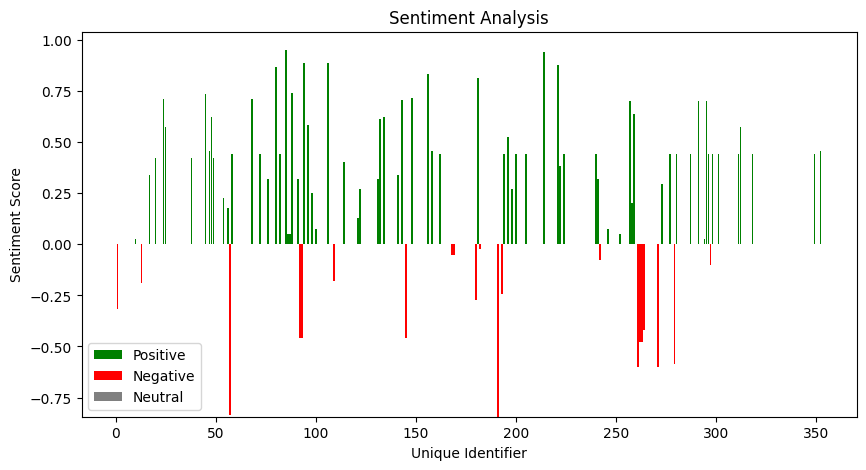

In [ ]:
#Create a new DataFrame with the sentiment scores for positive, negative and neutral texts
sentiment_df = pd.DataFrame({
'positive': grouped[grouped > 0],
'negative': grouped[grouped < 0],
'neutral': grouped[grouped == 0]
})

#Sort the DataFrame by the index (i.e., the unique identifier)
sentiment_df = sentiment_df.sort_index()

#Plot the sentiment scores as a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(sentiment_df.index, sentiment_df['positive'], color='green', label='Positive')
ax.bar(sentiment_df.index, sentiment_df['negative'], color='red', label='Negative')
ax.bar(sentiment_df.index, sentiment_df['neutral'], color='gray', label='Neutral', bottom=sentiment_df['negative'])

ax.set_xlabel('Unique Identifier')
ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment Analysis')
ax.legend() 

plt.show()

### Sentiment Analysis with Word Counts for Each Sentiment Label

In [ ]:
# Define a function to calculate the sentiment label for a given word
def get_sentiment_label(word):
    score = TextBlob(word).sentiment.polarity
    return 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')

# Apply the function to each word in the text_tokens_lemma column
sentiment_labels = []
for text in fdk['text_tokens_lemma']:
    sentence = ' '.join(text)  # Join the list of words back into a sentence
    for word in text:
        sentiment_labels.append((get_sentiment_label(word), word))

# Create a DataFrame with the sentiment label, the word, and its count
sentiment_counts = pd.DataFrame(sentiment_labels, columns=['sentiment', 'word']) \
    .groupby(['sentiment', 'word']) \
    .size() \
    .reset_index(name='count')


sentiment_counts

,sentiment,word,count
0,Negative,active,1
1,Negative,average,1
2,Negative,bad,3
3,Negative,center,1
4,Negative,confusing,1
...,...,...,...
610,Positive,super,1
611,Positive,supportive,1
612,Positive,thanks,1
613,Positive,whole,1


In [ ]:
sentiment_counts = pd.DataFrame(sentiment_labels, columns=['sentiment', 'word']) \
    .groupby(['sentiment', 'word']) \
    .size() \
    .reset_index(name='count')

# Separate the dataframe into three based on the sentiment label
positive_words = sentiment_counts[sentiment_counts['sentiment'] == 'Positive']
negative_words = sentiment_counts[sentiment_counts['sentiment'] == 'Negative']
neutral_words = sentiment_counts[sentiment_counts['sentiment'] == 'Neutral']


positive_words.head()
negative_words.head()
neutral_words.head()


,sentiment,word,count
30,Neutral,academic,2
31,Neutral,accent,1
32,Neutral,access,1
33,Neutral,accommodation,1
34,Neutral,according,3


In [ ]:
sentiment_score = fdk[['ID','sentiment_score']]
sentiment_score

,ID,sentiment_score
0,270,0.0000
1,185,0.0000
2,97,0.0000
3,165,0.0000
4,325,0.0000
...,...,...
348,92,-0.4588
349,196,0.5267
350,114,0.4019
351,230,0.0000


#Total Count of Sentiments 

In [ ]:
# Define a function to calculate the sentiment label for a given word
def get_sentiment_label(word):
    score = TextBlob(word).sentiment.polarity
    return 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')

# Apply the function to each word in the text_tokens_lemma column
sentiment_labels = []
for text in fdk['text_tokens_lemma']:
    sentence = ' '.join(text)  # Join the list of words back into a sentence
    for word in text:
        sentiment_labels.append((get_sentiment_label(word), word))

# Create a DataFrame with the sentiment label, the word, and its count
sentiment_total_counts = pd.DataFrame(sentiment_labels, columns=['sentiment', 'word']) \
    .groupby(['sentiment']) \
    .size() \
    .reset_index(name='total_count')


sentiment_total_counts

,sentiment,total_count
0,Negative,56
1,Neutral,1325
2,Positive,128


# Table of Unique Identifiers with Sentiment Analysis Results

In [ ]:
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
data_clean['sentiment'] = data_clean['text_tokens_lemma'].apply(lambda x: get_sentiment(' '.join(x)))
sentiment_counts = data_clean.groupby(['ID', 'sentiment']).size().unstack(fill_value=0)

# Rename the columns to include the sentiment type
sentiment_counts.columns = [f'{col}_count' for col in sentiment_counts.columns]

# Reset the index to make the 'id' column a regular column
sentiment_counts = sentiment_counts.reset_index()

# Print the resulting table
print(sentiment_counts.head())

   ID  Negative_count  Neutral_count  Positive_count
0   1               1              0               0
1   2               0              1               0
2   3               0              1               0
3   4               0              1               0
4   5               0              1               0


In [ ]:
# Sum the columns for each sentiment type to get the total count
positive_count = sentiment_counts['Positive_count'].sum()
negative_count = sentiment_counts['Negative_count'].sum()
neutral_count = sentiment_counts['Neutral_count'].sum()

# Print the total count for each sentiment type
print(f'Total positive count: {positive_count}')
print(f'Total negative count: {negative_count}')
print(f'Total neutral count: {neutral_count}')


Total positive count: 70
Total negative count: 20
Total neutral count: 263
